# Example usage of algorithms

This notebook demonstrates how our curriculum learning algorithms may be used in
the sequence-learning setting, and reproduces many of the plots found in the
main text.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from common import *
from env import *


class NormalDist:
    def __init__(self, loc=0, scale=1) -> None:
        self.loc = loc
        self.scale = scale
    
    def __call__(self):
        return np.random.normal(loc=self.loc, scale=self.scale)


def plot_traj_and_qr(traj, qr, n_step=1, save_path=None):
    fig = plt.gcf()
    ax = plt.gca()

    fig.set_size_inches((6.8, 2.5))
    qr = np.array(qr)
    qr = np.flip(qr.T, axis=0)
    im = ax.imshow(qr, aspect='auto', vmin=0, vmax=10, cmap='Greys')

    ticks = np.array([0, 5, 10]) * n_step
    ax.set_yticks(ticks, np.flip(np.array((0, 5, 10))))

    adj = -0.425 if n_step == 1 else 2.75
    ax.plot(10 * n_step - np.array(traj)[1:] + adj, color='red', lw=2)
    ax.set_xlim((0, len(traj) - 1.5))

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.25)
    ax.spines['left'].set_linewidth(1.25)
    ax.tick_params(labelsize = 18)
    ax.set_ylabel(r"Difficulty $(k)$", fontsize = 20)
    ax.set_xlabel(r"Steps", fontsize = 20)

    cb = fig.colorbar(mappable = im)
    cb.ax.tick_params(labelsize=18)
    cb.set_ticks([0,5,10])
    cb.set_label("$q$", fontsize = 20)

    fig.tight_layout()

    if save_path:
        plt.savefig(save_path)
        

def plot_traj_slices(qr, eps, n_steps=1, ax=None):
    qr = np.array(qr) + eps

    fig,ax = plt.subplots(1,1,figsize = (3,2.5))
    ax.plot(qr[:,0],'k-',lw=1.5,label = r"$q_1$")
    ax.plot(qr[:,2*n_steps],'k--',lw = 1.5,alpha = 0.5,label = r"$q_3$")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1.25)
    ax.spines['left'].set_linewidth(1.25)
    ax.tick_params(labelsize = 18)
    ax.set_yticks([0,5,10])
    ax.set_ylabel(r"$q$", fontsize = 20)
    ax.set_xlabel(r"Steps", fontsize = 20)
    fig.tight_layout()
    ax.legend()

# Incremental

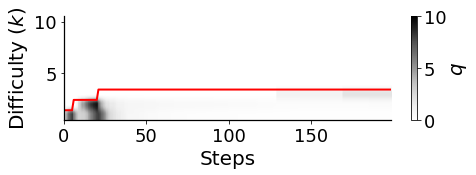

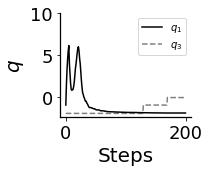

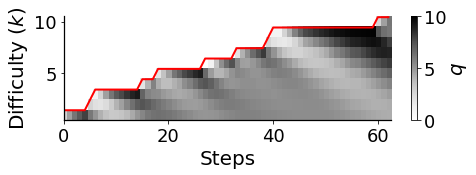

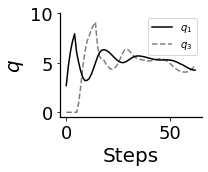

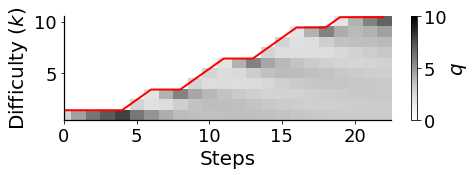

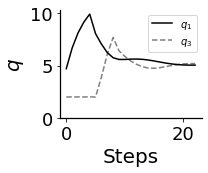

In [2]:
N = 10
eps_s = [-2, 0, 2]

for i, eps in enumerate(eps_s):
    traj, info = run_inc(eps=eps, goal_length=N)

    traj = traj[:200]
    qrs = np.array(info['qr'])[:200,:]

    plot_traj_and_qr(traj, qrs, n_step=1)
    plt.show()

    plot_traj_slices(qrs, eps)
    plt.show()


# POMCP

POMCP takes significant time to run. The script `other/run_pomcp.py` will
generate a datafile `pomcp.pkl` containing run statistics. Use the datafile
below to plot these statistics.

In [3]:
df = pd.read_pickle('pomcp.pkl')

ROW {'eps': -2.0, 'goal_length': 10, 'gamma': 0.95}


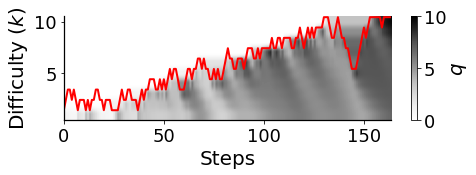

In [4]:
row = df.iloc[10]
print('ROW', row.run_params)

traj, info = row['runs'][1], row['info'][1]
plot_traj_and_qr(traj, info['qr'], n_step=1)


# Adaptive

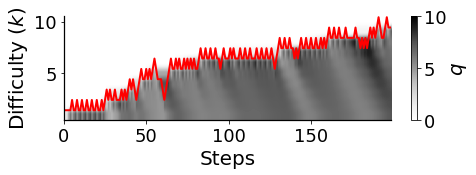

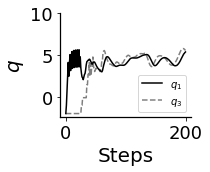

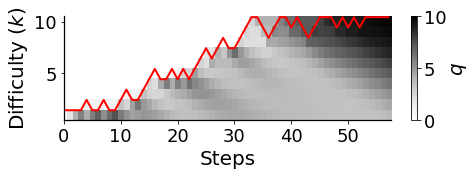

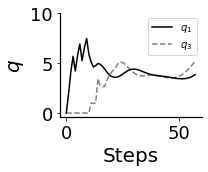

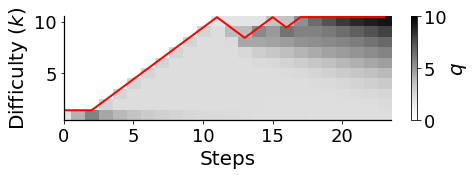

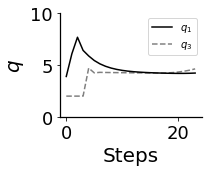

In [5]:
N = 10
eps_s = [-2, 0, 2]

for i, eps in enumerate(eps_s):
    traj, info = run_adp(eps=eps, goal_length=N)

    traj = traj[:200]
    qrs = np.array(info['qr'])[:200,:]

    plot_traj_and_qr(traj, qrs, n_step=1)
    plt.show()

    plot_traj_slices(qrs, eps)
    plt.show()

# Benchmarks

In [6]:
np.random.seed(1)

n_iters = 10
Ns = [3, 5, 10]
eps = np.linspace(-2, 2, num=5)

T = 3
lr = 0.1
alpha = 0.1
beta = 1
k = 5

raw_data = []

for N in tqdm(Ns):
    for e in eps:
        cases = [
            Case('ADP', run_adp, {'eps': e, 'goal_length': N}, []),
            Case('INC', run_inc, {'eps': e, 'goal_length': N}, []),
            Case('Online', run_online, {'eps': e, 'goal_length': N, 'alpha': alpha, 'beta': beta}, []),
            Case('Naive', run_naive, {'eps': e, 'goal_length': N, 'alpha': alpha, 'beta': beta, 'k': k}, []),
            Case('Sampling', run_sampling, {'eps': e, 'goal_length': N, 'alpha': alpha, 'k': k}, []),
            Case('Window', run_window, {'eps': e, 'goal_length': N, 'alpha': alpha, 'beta': beta, 'k': k}, []),
            Case('Random', run_random, {'eps': e, 'goal_length': N}, []),
            Case('Final', run_final_task_only, {'eps': e, 'goal_length': N}, []),
        ]

        run_exp(n_iters=n_iters, cases=cases, max_steps=N * 100, lr=lr, T=T)
        raw_data.extend(cases)


df_bench = pd.DataFrame(raw_data)
df = pd.concat((df, df_bench), ignore_index=True)   # df loaded from `pomcp.pkl` above

  0%|          | 0/3 [00:00<?, ?it/s]/home/grandpaa/workspace/trails/venv_trail/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/grandpaa/workspace/trails/venv_trail/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/grandpaa/workspace/trails/venv_trail/lib/python3.10/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
100%|██████████| 3/3 [00:25<00:00,  8.52s/it]


In [7]:
# setting up for benchmark plotting
fig_dir = Path('fig/us_v_matiisen_v_pomcp')
if not fig_dir.exists():
    fig_dir.mkdir(parents=True)

def extract_plot_vals(row):
    traj_lens = [len(traj) for traj in row['runs']]

    return pd.Series([
        row['name'],
        row['run_params']['goal_length'],
        np.round(row['run_params']['eps'], decimals=2),
        traj_lens
    ], index=['name', 'N', 'eps', 'traj_lens'])

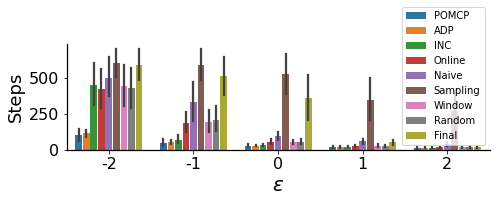

In [8]:
plot_df = df.apply(extract_plot_vals, axis=1).explode('traj_lens')
plt.gcf().set_size_inches(7, 2.5)

g = sns.barplot(plot_df, x='eps', y='traj_lens', hue='name', width=0.8, gap=0.1)
g.set_xlabel(r'$\varepsilon$', fontsize=20)
g.set_ylabel('Steps', fontsize=18)
g.tick_params(labelsize=16)
g.set_xticks(g.get_xticks())
g.set_xticklabels([-2, -1, 0, 1, 2])
g.legend().set_title('')

g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
g.spines['bottom'].set_linewidth(1.25)
g.spines['left'].set_linewidth(1.25)

plt.gcf().tight_layout()
plt.savefig(f'fig/benchmark_condensed.svg')
plt.show()

# Continuous curricula

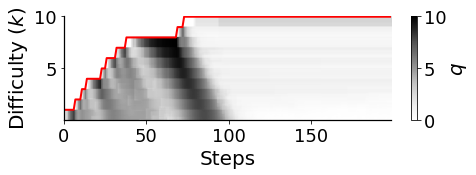

In [9]:
N = 10
eps_s = [-2]

for i, eps in enumerate(eps_s):
    traj, info = run_inc_cont(eps=eps, goal_length=N)

    traj = traj[:200]
    qrs = np.array(info['qr'])[:200,:]
    plot_traj_and_qr(traj, qrs, n_step=100)
    plt.savefig('fig/incremental_qs.svg')
    plt.show()


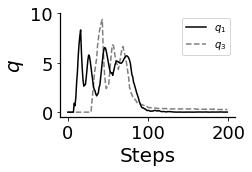

In [10]:
N = 10
epss = [-2]
for ie,eps in enumerate(epss):
    traj, info = run_inc_cont(eps=eps, goal_length=N)
    qrs = np.array(info['qr'])[:200] - eps

    plot_traj_slices(qrs, eps, n_steps=100)

    plt.savefig('fig/inc_traj_slice.svg')
    plt.gcf().set_size_inches(4, 2.5)
    plt.show()


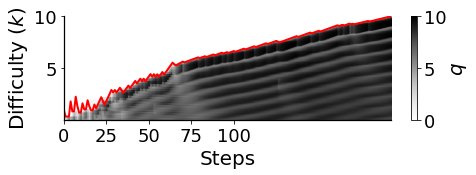

In [11]:
N = 10
eps_s = [-2]

for i, eps in enumerate(eps_s):
    traj, info = run_adp_cont(eps=eps, goal_length=N)

    plot_traj_and_qr(traj, info['qr'], n_step=100)
    plt.gcf().set_size_inches(6.8, 2.5)
    plt.gca().set_xticks([0, 25, 50, 75, 100])
    plt.savefig('fig/adp_qs.svg')
    plt.show()

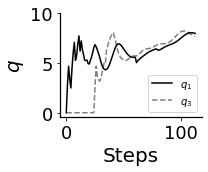

In [12]:
np.random.seed(6)
N = 10
epss = [-2]
for ie,eps in enumerate(epss):
    traj, info = run_adp_cont(eps=eps, goal_length=N)

    qr = np.array(info['qr']) - eps
    plot_traj_slices(qr, eps, n_steps=100)

    plt.gcf().set_size_inches(3, 2.5)
    plt.savefig('fig/adp_traj_slice.svg')
    plt.show()

In [13]:
### Benchmarks
n_iters = 5
Ns = [10]
eps = np.linspace(-3, 2, num=6)

T = 3
lr = 0.1
alpha = 0.1
beta = 1
k = 5

raw_data = []

for N in tqdm(Ns):
    for e in eps:
        cases = [
            Case('ADP', run_adp_cont, {'eps': e, 'goal_length': N}, []),
            Case('INC', run_inc_cont, {'eps': e, 'goal_length': N}, []),
            
            # Random and Final do not work on continuous curricula, and so are commented out
            # ---
            # Case('Random', run_random, {'eps': e, 'goal_length': N, 'is_cont': True}, []),
            # Case('Final', run_final_task_only, {'eps': e, 'goal_length': N, 'is_cont': True}, []),
        ]

        run_exp(n_iters=n_iters, cases=cases, max_steps=N * 100, lr=lr, T=T)
        raw_data.extend(cases)

df = pd.DataFrame(raw_data)

100%|██████████| 1/1 [01:20<00:00, 80.35s/it]


In [14]:
# Setting up for benchmarks plotting
fig_dir = Path('fig/benchmark_cont')
if not fig_dir.exists():
    fig_dir.mkdir(parents=True)

def extract_plot_vals(row):
    traj_lens = [len(traj) for traj in row['runs']]

    return pd.Series([
        row['name'],
        row['run_params']['goal_length'],
        np.round(row['run_params']['eps'], decimals=2),
        traj_lens
    ], index=['name', 'N', 'eps', 'traj_lens'])

In [15]:
plot_df = df.apply(extract_plot_vals, axis=1).explode('traj_lens')

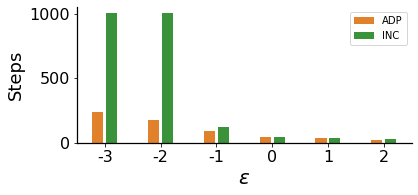

In [16]:
plt.gcf().set_size_inches(6, 2.5)

g = sns.barplot(plot_df, x='eps', y='traj_lens', hue='name', palette=['C1', 'C2'], errorbar=None, width=0.5, gap=0.2)
g.set_xlabel(r'$\varepsilon$', fontsize=20)
g.set_ylabel('Steps', fontsize=18)
g.tick_params(labelsize=16)
g.set_yticks([0, 500, 1000])
g.set_xticks(g.get_xticks())
g.set_xticklabels([-3, -2, -1, 0, 1, 2])
g.legend().set_title('')

g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
g.spines['bottom'].set_linewidth(1.25)
g.spines['left'].set_linewidth(1.25)

plt.savefig('fig/cont_bench.svg')

# Heterogeneous epsilon

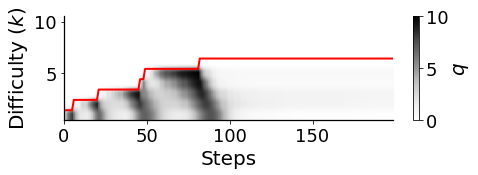

In [17]:
N = 10
eps_s = [-1]

for i, eps in enumerate(eps_s):
    traj, info = run_inc(eps=NormalDist(loc=eps, scale=1), goal_length=N)

    traj = traj[:200]
    qrs = np.array(info['qr'])[:200,:]
    plot_traj_and_qr(traj, qrs)
    plt.gcf().tight_layout()
    plt.savefig('fig/incremental_qs_hetero.svg')
    plt.show()

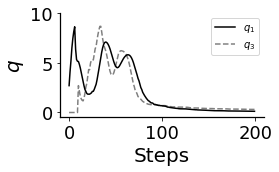

In [18]:
N = 10
epss = [-1]
for ie,eps in enumerate(epss):
    traj, info = run_inc(eps=NormalDist(loc=eps, scale=1), goal_length=N)
    qrs = np.array(info['qr'])[:200] - eps

    plot_traj_slices(qrs, eps)

    plt.savefig('fig/inc_traj_slice_hetero.svg')
    plt.gcf().set_size_inches(4, 2.5)
    
    plt.gcf().tight_layout()
    plt.show()

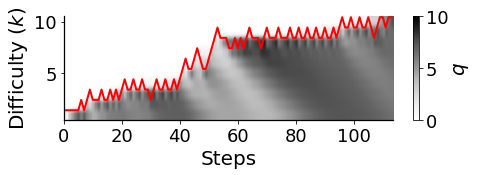

In [19]:
N = 10
eps_s = [-1]

for i, eps in enumerate(eps_s):
    traj, info = run_adp(eps=NormalDist(loc=eps, scale=1), goal_length=N)

    traj = traj[:200]
    qrs = np.array(info['qr'])[:200,:]
    plot_traj_and_qr(traj, qrs)
    plt.gcf().tight_layout()
    plt.savefig('fig/adp_qs_hetero.svg')
    plt.show()

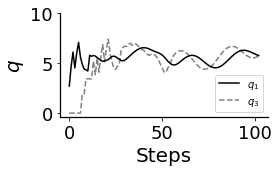

In [20]:
N = 10
epss = [-1]
for ie,eps in enumerate(epss):
    traj, info = run_adp(eps=NormalDist(loc=eps, scale=1), goal_length=N)
    qrs = np.array(info['qr'])[:200] - eps

    plot_traj_slices(qrs, eps)

    plt.savefig('fig/adp_traj_slice_hetero.svg')
    plt.gcf().set_size_inches(4, 2.5)
    
    plt.gcf().tight_layout()
    plt.show()

In [21]:
# BENCHMARKS
n_iters = 10
Ns = [10]
eps = np.linspace(-2, 2, num=5)
sigs = [1, 3]

T = 3
lr = 0.1

raw_data = []

for N in tqdm(Ns):
    for e in eps:
        for s in sigs:
            eps_dist = NormalDist(loc=e, scale=s)
            cases = [
                Case('Adaptive', run_adp, {'eps': eps_dist, 'goal_length': N}, []),
                Case('Incremental', run_inc, {'eps': eps_dist, 'goal_length': N}, []),
                Case('Random', run_random, {'eps': eps_dist, 'goal_length': N}, []),
            ]

            run_exp(n_iters=n_iters, cases=cases, max_steps=N * 100, lr=lr, T=T)
            raw_data.extend(cases)

df = pd.DataFrame(raw_data)

100%|██████████| 1/1 [00:13<00:00, 13.69s/it]


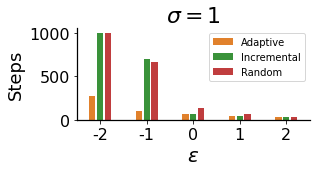

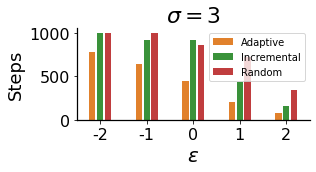

In [22]:
# setting up for benchmark plotting
fig_dir = Path('fig/hetero_eps')
if not fig_dir.exists():
    fig_dir.mkdir(parents=True)

def extract_plot_vals(row):
    traj_lens = [len(traj) for traj in row['runs']]

    return pd.Series([
        row['name'],
        row['run_params']['goal_length'],
        np.round(row['run_params']['eps'].loc, decimals=2),
        np.round(row['run_params']['eps'].scale, decimals=2),
        traj_lens
    ], index=['name', 'N', 'eps', 'sig', 'traj_lens'])


plot_df = df.apply(extract_plot_vals, axis=1).explode('traj_lens')

for s in sigs:
    plt.gcf().set_size_inches(4.5, 2.5)

    g = sns.barplot(plot_df[plot_df['sig'] == s], x='eps', y='traj_lens', hue='name', palette=['C1', 'C2', 'C3'], errorbar=None, width=0.5, gap=0.2)
    g.set_xlabel(r'$\varepsilon$', fontsize=20)
    g.set_ylabel('Steps', fontsize=18)
    g.tick_params(labelsize=16)
    g.set_yticks([0, 500, 1000])
    g.set_xticks(g.get_xticks())
    g.set_xticklabels([-2, -1, 0, 1, 2])
    g.legend().set_title('')

    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    g.spines['bottom'].set_linewidth(1.25)
    g.spines['left'].set_linewidth(1.25)

    g.set_title(fr'$\sigma={s}$', fontsize=22)

    plt.gcf().tight_layout()
    plt.savefig(fig_dir / f'hetero_eps_sig_{s}.svg')
    plt.show()